# Sagniru (Non-Residential)

## Header Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import warnings
import threading
import time

In [2]:
# Suppress DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [4]:
# Set the font style
font_style = {'family': 'arial', 'weight': 'normal', 'size': 7
              #, 'color':'darkred'
             }

# Apply the font style
plt.rc('font', **font_style)

## Read the File

In [5]:
sag = pd.read_csv('nr1.csv')

## Evaluate Total Power

In [6]:
phases = [1, 2, 3, 'NPE']
P1 = np.zeros(len(sag))
P2 = np.zeros(len(sag))
P3 = np.zeros(len(sag))
Pn = np.zeros(len(sag))

P = [P1, P2, P3, Pn]

for phase in range(len(phases)):
    for i in range(3, 50, 2):
        P[phase] += (sag[f"har{i:02}V{phases[phase]}_Avg [V]"] * sag[f"har{i:02}I{phases[phase]}_Avg [A]"])

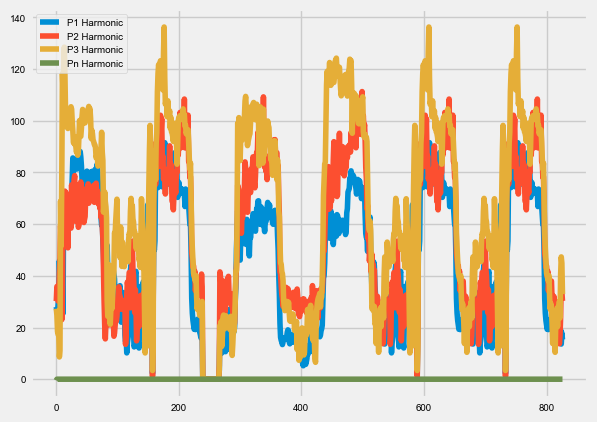

In [7]:
s_pwr = pd.DataFrame({'Datetime':sag['Time'], 'P1 Harmonic':P1, 'P2 Harmonic':P2, 'P3 Harmonic':P3, 'Pn Harmonic':Pn})
s_pwr.plot()
plt.savefig('sag_raw_on_each_phase.jpg', dpi = 377)
plt.show()

In [70]:
s_pwr.head(3)

,Datetime,P1 Harmonic,P2 Harmonic,P3 Harmonic,Pn Harmonic
0,8/17/2023 5:06:00 PM,27.965106,30.220078,27.279160,-0.489929
1,8/17/2023 5:16:00 PM,26.190977,35.875308,24.740722,0.000000
2,8/17/2023 5:26:00 PM,26.004550,35.289023,18.476894,0.000000


<br><br>
## Normalize

The graph above reveals a zero points which is clearly an error, so we fill it with median.

<Axes: >

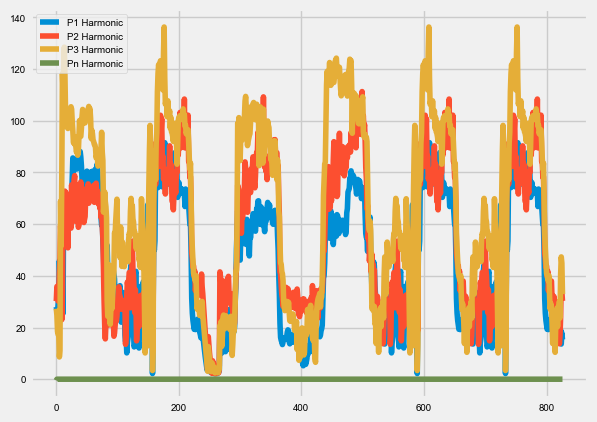

In [9]:
for _ in range(10):
    p1_zeroes = s_pwr['P1 Harmonic'] <= 2
    s_pwr['P1 Harmonic'][p1_zeroes] = s_pwr['P1 Harmonic'].rolling(window=10).mean()

    p2_zeroes = s_pwr['P2 Harmonic'] <= 2
    s_pwr['P2 Harmonic'][p2_zeroes] = s_pwr['P2 Harmonic'].rolling(window=10).mean()

    p3_zeroes = s_pwr['P3 Harmonic'] <= 2
    s_pwr['P3 Harmonic'][p3_zeroes] = s_pwr['P3 Harmonic'].rolling(window=10).mean()

s_pwr.plot()

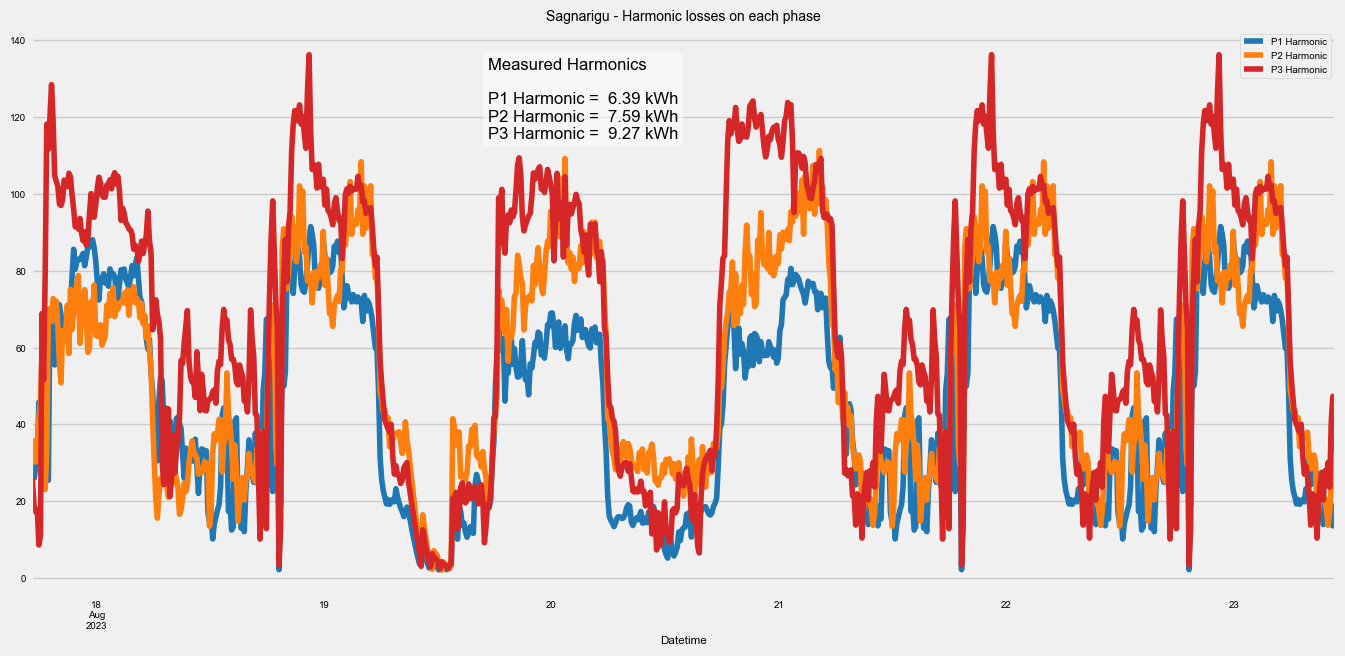

In [10]:
fig, axe = plt.subplots(figsize=(15, 7))

s_pwr_ = s_pwr.set_index('Datetime')
s_pwr_.index = pd.to_datetime(s_pwr_.index, format="%m/%d/%Y %I:%M:%S %p")
s_pwr_['P1 Harmonic'].plot(ax=axe, color=color_pal[0], title='Sagnarigu - Harmonic losses on each phase', legend='P1 Harmonic')
s_pwr_['P2 Harmonic'].plot(ax=axe, color=color_pal[1], legend='P2 Harmonic')
s_pwr_['P3 Harmonic'].plot(ax=axe, color=color_pal[3], legend='P3 Harmonic')

axe.legend(['P1 Harmonic', 'P2 Harmonic', 'P3 Harmonic'])
# Add text annotation at a specific point
axe.text(0.35, 0.95, 
         f'Measured Harmonics\n\nP1 Harmonic = {s_pwr['P1 Harmonic'].sum()/6000:>5.2f} kWh\nP2 Harmonic = {s_pwr['P2 Harmonic'].sum()/6000:>5.2f} kWh\nP3 Harmonic = {s_pwr['P3 Harmonic'].sum()/6000:>5.2f} kWh', transform=axe.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('sag_harmonics_on_each_phase.jpg', dpi = 307)
plt.show()

## Separating the Harmonic Power on each phase (using actual data)

In [27]:
s_p1 = pd.DataFrame({'Datetime':s_pwr['Datetime'], 'P1_Harmonic':s_pwr['P1 Harmonic']})
s_p2 = pd.DataFrame({'Datetime':s_pwr['Datetime'], 'P2_Harmonic':s_pwr['P2 Harmonic']})
s_p3 = pd.DataFrame({'Datetime':s_pwr['Datetime'], 'P3_Harmonic':s_pwr['P3 Harmonic']})
s_pn = pd.DataFrame({'Datetime':s_pwr['Datetime'], 'Pn_Harmonic':s_pwr['Pn Harmonic']})

In [28]:
s_p1 = s_p1.set_index('Datetime')
s_p1.index = pd.to_datetime(s_p1.index, format="%m/%d/%Y %I:%M:%S %p")

s_p2 = s_p2.set_index('Datetime')
s_p2.index = pd.to_datetime(s_p2.index, format="%m/%d/%Y %I:%M:%S %p")

s_p3 = s_p3.set_index('Datetime')
s_p3.index = pd.to_datetime(s_p3.index, format="%m/%d/%Y %I:%M:%S %p")

s_pn = s_pn.set_index('Datetime')
s_pn.index = pd.to_datetime(s_pn.index, format="%m/%d/%Y %I:%M:%S %p")

## Feature Creation

In [29]:
def create_features(df):
    """
    Creates time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    
    return df

In [30]:
s_p1 = create_features(s_p1)   
s_p2 = create_features(s_p2)   
s_p3 = create_features(s_p3)
s_pn = create_features(s_pn)

s_p2.head()

,P2_Harmonic,hour,minute,dayofweek
Datetime,,,,
2023-08-17 17:06:00,30.220078,17,6,3
2023-08-17 17:16:00,35.875308,17,16,3
2023-08-17 17:26:00,35.289023,17,26,3
2023-08-17 17:36:00,30.232898,17,36,3
2023-08-17 17:46:00,33.703291,17,46,3


In [31]:
set(s_p2['dayofweek'])

{0, 1, 2, 3, 4, 5, 6}

## Boxplot of Feature Importance

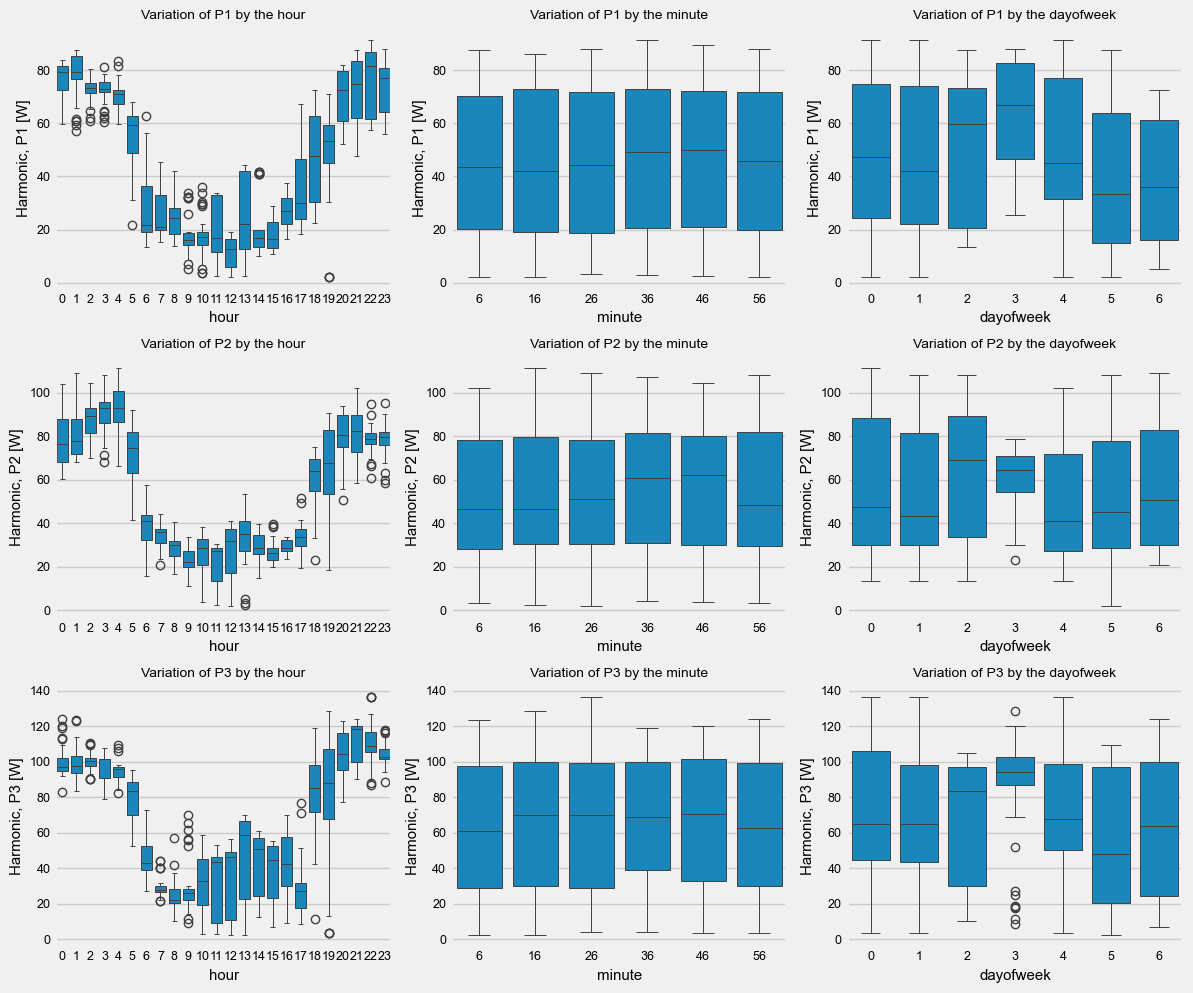

In [86]:
s_ps = [s_p1, s_p2, s_p3]
ps = [1, 2, 3]
_2nd_iter = ['hour', 'minute', 'dayofweek']

# Create subplots
fig, axes = plt.subplots(nrows=len(s_ps), ncols=3, figsize=(12, 10))

axes = axes.flatten()

# Set the font style
font_style = {'family': 'arial', 'weight': 'normal', 'size': 9
              #, 'color':'darkred'
             }

# Apply the font style
plt.rc('font', **font_style)

i = 0
for ctr in range(len(s_ps)):
    for b in range(3):
        sns.boxplot(x=_2nd_iter[b], y=f'P{ps[ctr]}_Harmonic', data=s_ps[ctr], ax=axes[i], linewidth=0.7)
        axes[i].set_title(f'Variation of P{ps[ctr]} by the {_2nd_iter[b]}', fontsize=10)
        axes[i].set_ylabel(f'Harmonic, P{ps[ctr]} [W]')
        i += 1

# Adjust layout
plt.tight_layout()

plt.savefig('feature_variations.jpg', dpi=200)

# Show the plot
plt.show()

## Model Creation

In [33]:
def mape(y_true, y_pred):
    """mape: mean_absolute_percentage_error"""
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

<br>

### Phase 1 (P1)

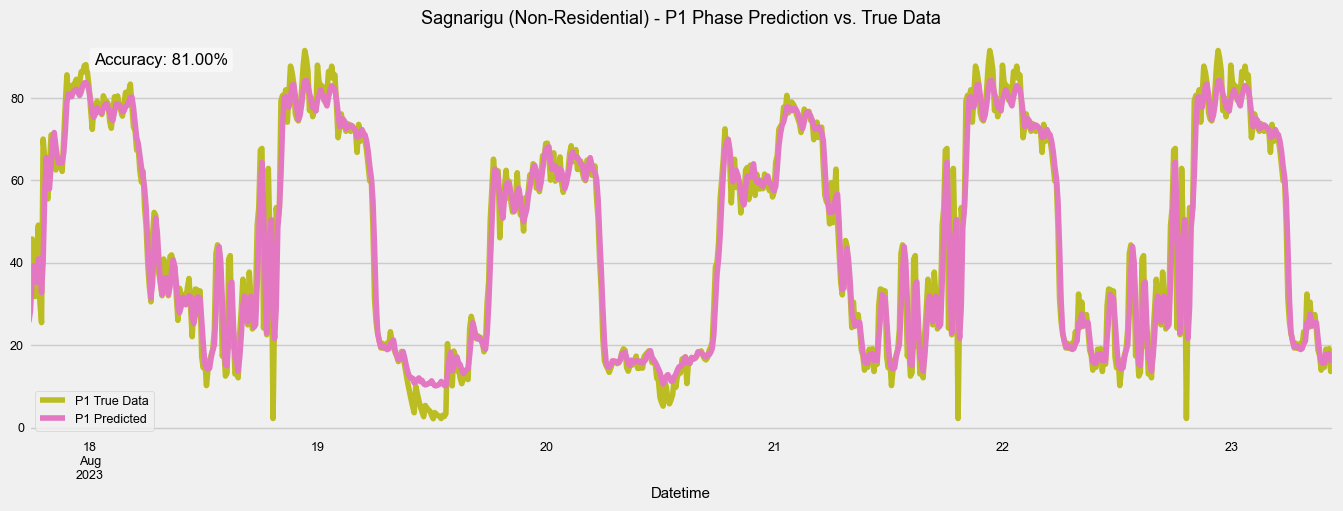

In [87]:
# Create a deep copy
s_p1_ = s_p1.copy(deep=True)

# Create lags
s_p1_['lag_1'] = s_p1_['P1_Harmonic'].shift(1)
s_p1_['lag_2'] = s_p1_['P1_Harmonic'].shift(2)
s_p1_['lag_3'] = s_p1_['P1_Harmonic'].shift(3)

# Create rolling window features
s_p1_['rolling_mean_3'] = s_p1_['P1_Harmonic'].rolling(window=3).mean()
s_p1_['rolling_std_3'] = s_p1_['P1_Harmonic'].rolling(window=3).std()
s_p1_['rolling_var_3'] = s_p1_['P1_Harmonic'].rolling(window=3).sum() 

# Dropna
s_p1_.dropna(inplace=True)

# Feature creation and extraction.
sp1_X = s_p1_.drop(columns=['P1_Harmonic'])
sp1_y = s_p1_['P1_Harmonic']

# Train the SVR Model
s_p1_SVR = SVR(kernel='rbf', C=1.3, epsilon=0.3)
s_p1_SVR.fit(sp1_X, sp1_y)

# Make predictions
s_p1_['Predictions'] = s_p1_SVR.predict(sp1_X)

# Evaluate Accuracy
p1_accuracy = 100 - mape(s_p1_['P1_Harmonic'], s_p1_['Predictions'])
#print(f'Accuracy (%): {p1_accuracy: .2f}%')

# Make plots.
ax = s_p1_[['P1_Harmonic']].plot(figsize=(15,5), color=color_pal[-2], title="Sagnarigu (Non-Residential) - P1 Phase Prediction vs. True Data")
s_p1_['Predictions'].plot(ax=ax, style='-', color=color_pal[-4])

accur = f'{p1_accuracy:.2f}%'
ax.set_xlabel('Datetime', rotation=0)
ax.legend(['P1 True Data', 'P1 Predicted'])

# Add text annotation at a specific point
ax.text(0.05, 0.95, f'Accuracy: {accur}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.savefig('sag_p1__true_vs_predicted.jpg', dpi=307)
plt.show()

In [35]:
s_p1_.head(2)

,P1_Harmonic,hour,minute,dayofweek,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,rolling_var_3,Predictions
Datetime,,,,,,,,,,,
2023-08-17 17:36:00,28.859631,17,36,3,26.004550,26.190977,27.965106,27.018386,1.597287,81.055158,25.613246
2023-08-17 17:46:00,32.168508,17,46,3,28.859631,26.004550,26.190977,29.010896,3.084762,87.032689,28.357584


<br>

### Phase 2 (P2)

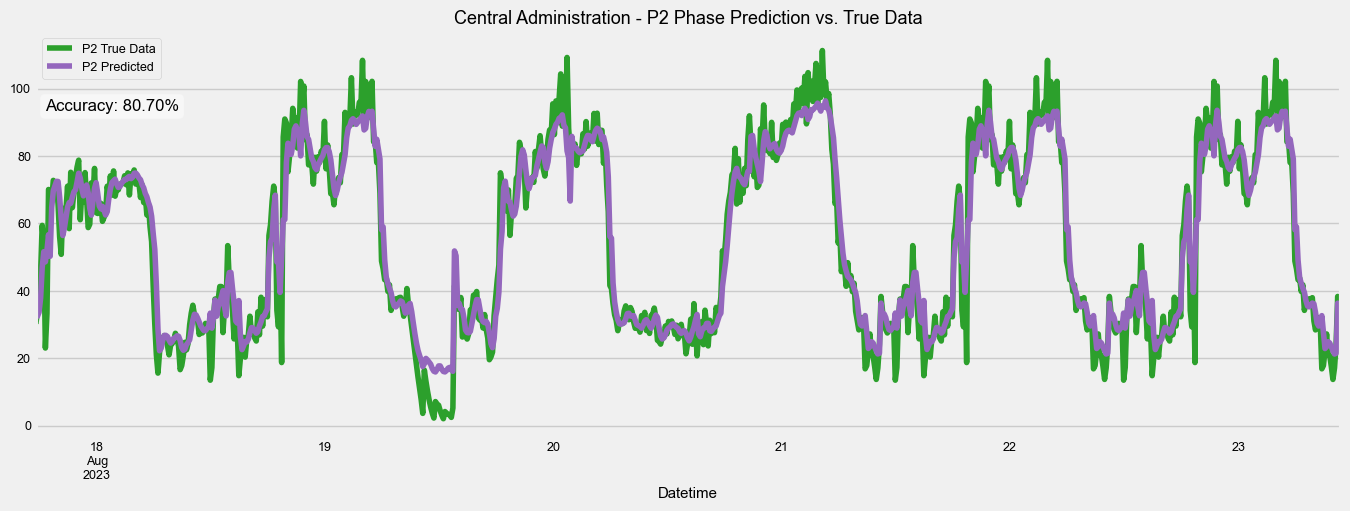

In [89]:
# Create a deep copy
s_p2_ = s_p2.copy(deep=True)

# Create lags
s_p2_['lag_1'] = s_p2_['P2_Harmonic'].shift(1)
s_p2_['lag_2'] = s_p2_['P2_Harmonic'].shift(2)
s_p2_['lag_3'] = s_p2_['P2_Harmonic'].shift(3)

# Create rolling window features
s_p2_['rolling_mean_3'] = s_p2_['P2_Harmonic'].rolling(window=3).mean()
s_p2_['rolling_std_3'] = s_p2_['P2_Harmonic'].rolling(window=3).std()
s_p2_['rolling_var_3'] = s_p2_['P2_Harmonic'].rolling(window=3).var()

# Dropna
s_p2_.dropna(inplace=True)

# Feature creation and extraction.
sp2_X = s_p2_.drop(columns=['P2_Harmonic'])
sp2_y = s_p2_['P2_Harmonic']

# Train the SVR Model
s_p2_SVR = SVR(kernel='rbf', C=1.3, epsilon=0.3)
s_p2_SVR.fit(sp2_X, sp2_y)

# Make predictions
s_p2_['Predictions'] = s_p2_SVR.predict(sp2_X)

# Evaluate Accuracy
p2_accuracy = 100 - mape(s_p2_['P2_Harmonic'], s_p2_['Predictions'])

# Make plots.
ax = s_p2_[['P2_Harmonic']].plot(figsize=(15,5), color=color_pal[2], title="Central Administration - P2 Phase Prediction vs. True Data")
s_p2_['Predictions'].plot(ax=ax, style='-', color=color_pal[4])

accur = f'{p2_accuracy:.2f}%'
ax.set_xlabel('Datetime', rotation=0)
ax.legend(['P2 True Data', 'P2 Predicted'])

# Add text annotation at a specific point
ax.text(0.007, 0.835, f'Accuracy: {accur}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.savefig('sag_p2__true_vs_predicted.jpg', dpi=307)
plt.show()

<br>

### Phase 3 (P3)

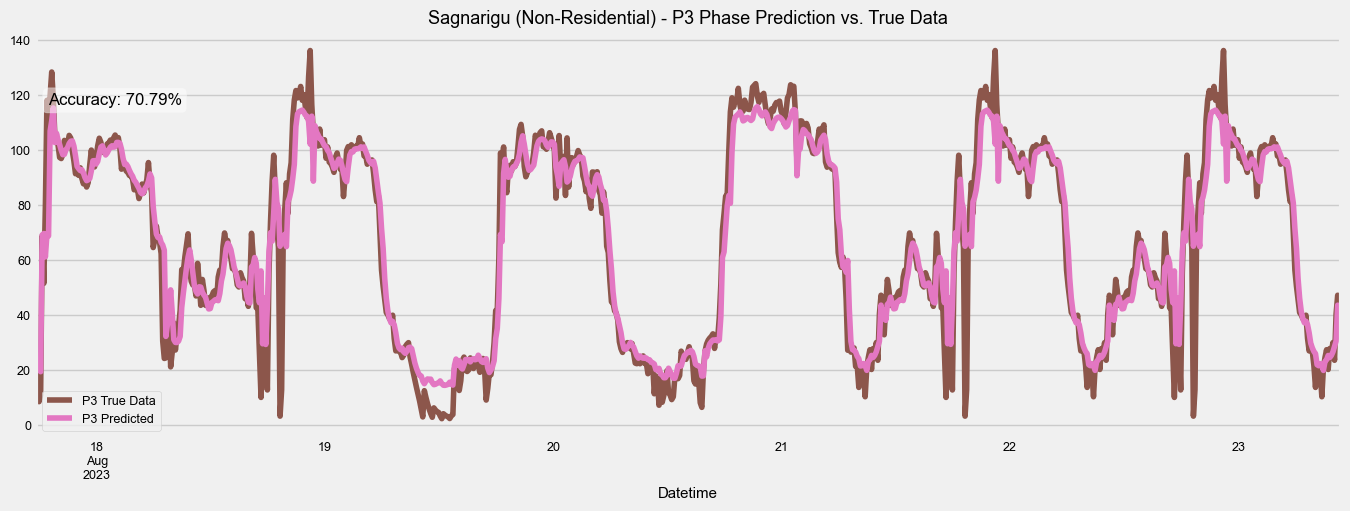

In [38]:
# Create a deep copy
s_p3_ = s_p3.copy(deep=True)

# Create lags
s_p3_['lag_1'] = s_p3_['P3_Harmonic'].shift(1)
s_p3_['lag_2'] = s_p3_['P3_Harmonic'].shift(2)
s_p3_['lag_3'] = s_p3_['P3_Harmonic'].shift(3)

# Create rolling window features
s_p3_['rolling_mean_3'] = s_p3_['P3_Harmonic'].rolling(window=3).mean()
s_p3_['rolling_std_3'] = s_p3_['P3_Harmonic'].rolling(window=3).std()
s_p3_['rolling_var_3'] = s_p3_['P3_Harmonic'].rolling(window=3).var()

# Dropna
s_p3_.dropna(inplace=True)

# Feature creation and extraction.
sp3_X = s_p3_.drop(columns=['P3_Harmonic'])
sp3_y = s_p3_['P3_Harmonic']

# Train the SVR Model
s_p3_SVR = SVR(kernel='rbf', C=1.3, epsilon=0.3)
s_p3_SVR.fit(sp3_X, sp3_y)

# Make predictions
s_p3_['Predictions'] = s_p3_SVR.predict(sp3_X)

# Evaluate Accuracy
p3_accuracy = 100 - mape(s_p3_['P3_Harmonic'], s_p3_['Predictions'])

# Make plots.
ax = s_p3_[['P3_Harmonic']].plot(figsize=(15,5), color=color_pal[5], title="Sagnarigu (Non-Residential) - P3 Phase Prediction vs. True Data")
s_p3_['Predictions'].plot(ax=ax, style='-', color=color_pal[6])

accur = f'{p3_accuracy:.2f}%'
ax.set_xlabel('Datetime', rotation=0)
ax.legend(['P3 True Data', 'P3 Predicted'])

# Add text annotation at a specific point
ax.text(0.009, 0.850, f'Accuracy: {accur}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.savefig('sag_p3__true_vs_predicted.jpg', dpi=307)
plt.show()

<br><br><br>
## Prediction on Future and Unseen Data

### Phase 1 (P1)

In [41]:
# The Seed
s_p1_seed = s_p1_.tail(10).copy(deep=True)
s_p1_seed.head(3)

,P1_Harmonic,hour,minute,dayofweek,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,rolling_var_3,Predictions
Datetime,,,,,,,,,,,
2023-08-23 09:16:00,17.468254,9,16,2,18.819144,23.729850,27.416263,20.005749,3.295136,60.017248,18.344618
2023-08-23 09:26:00,13.926194,9,26,2,17.468254,18.819144,23.729850,16.737864,2.526923,50.213592,15.931079
2023-08-23 09:36:00,15.989628,9,36,2,13.926194,17.468254,18.819144,15.794692,1.779058,47.384076,15.625186


In [42]:
# number of years to predict for.
sp1_n = 5

sp1_start_date = datetime.strptime(str(list(s_p1_seed.index)[0]), '%Y-%m-%d %H:%M:%S')
sp1_end_date = sp1_start_date + relativedelta(years=sp1_n)

sp1_dates = np.array(s_p1_seed.index.astype(str))
sp1_harmonics = np.array(s_p1_seed['P1_Harmonic'].values)
sp1_hr = np.array(s_p1_seed['hour'].values)
sp1_min = np.array(s_p1_seed['minute'].values)
sp1_dow = np.array(s_p1_seed['dayofweek'].values)
sp1_lag_1 = np.array(s_p1_seed['lag_1'].values)
sp1_lag_2 = np.array(s_p1_seed['lag_2'].values)
sp1_lag_3 = np.array(s_p1_seed['lag_3'].values)
sp1_roll_mean_3 = np.array(s_p1_seed['rolling_mean_3'].values)
sp1_roll_std_3 = np.array(s_p1_seed['rolling_std_3'].values)
sp1_roll_var_3 = np.array(s_p1_seed['rolling_var_3'].values)
sp1_y_pred = np.array(s_p1_seed['Predictions'].values)

# Pre-allocate memory for future values
sp1_prediction_horizon = int((sp1_end_date - sp1_start_date).total_seconds() // 600)  # 10-minute increments
sp1_future_dates = np.empty(sp1_prediction_horizon, dtype="U19")  # Pre-allocate date array (string format)
sp1_future_p1_h = np.empty(sp1_prediction_horizon)
sp1_future_lag_1 = np.empty(sp1_prediction_horizon)
sp1_future_lag_2 = np.empty(sp1_prediction_horizon)
sp1_future_lag_3 = np.empty(sp1_prediction_horizon)
sp1_future_roll_mean_3 = np.empty(sp1_prediction_horizon)
sp1_future_roll_std_3 = np.empty(sp1_prediction_horizon)
sp1_future_roll_var_3 = np.empty(sp1_prediction_horizon)
sp1_future_hr = np.empty(sp1_prediction_horizon, dtype=int)
sp1_future_min = np.empty(sp1_prediction_horizon, dtype=int)
sp1_future_dow = np.empty(sp1_prediction_horizon, dtype=int)
sp1_future_y_pred = np.empty(sp1_prediction_horizon)

# Initialize current time from the last date
sp1_current_date = datetime.strptime(sp1_dates[-1], '%Y-%m-%d %H:%M:%S')

i = 0

In [43]:
def sp1_timer():
    start_time = time.time()
    while not task1_done:
        elapsed_time = time.time() - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"\033[1;95mElapsed time: {int(hours):02}:{int(minutes):02}:{int(seconds):02} (Run {i:,} out of {sp1_prediction_horizon:,})", end='\r')
        time.sleep(0.0001)  # Update every second

In [44]:
task1_done = False

timer1_thread = threading.Thread(target=sp1_timer)
timer1_thread.start()

# Loop to generate predictions
while i < sp1_prediction_horizon:
    # Advance time by 10 minutes
    sp1_current_date += timedelta(minutes=10)
    sp1_current_hr = sp1_current_date.hour
    sp1_current_min = sp1_current_date.minute
    sp1_current_dow = sp1_current_date.weekday()
    
    # Append new values to the arrays
    sp1_future_dates[i] = sp1_current_date.strftime('%Y-%m-%d %H:%M:%S')
    sp1_future_hr[i] = sp1_current_hr
    sp1_future_min[i] = sp1_current_min
    sp1_future_dow[i] = sp1_current_dow
    sp1_future_p1_h[i] = sp1_y_pred[-1]  # Previous prediction becomes the new harmonic value
    
    # Update lag features
    sp1_future_lag_1[i] = sp1_future_p1_h[i - 1] if i > 0 else sp1_harmonics[-1]
    sp1_future_lag_2[i] = sp1_future_lag_1[i - 1] if i > 1 else sp1_lag_1[-1]
    sp1_future_lag_3[i] = sp1_future_lag_2[i - 1] if i > 2 else sp1_lag_2[-1]
    
    # Compute rolling statistics (using pre-existing values)
    sp1_window_p1_h = np.concatenate((sp1_harmonics[-2:], sp1_future_p1_h[:i+1]))[-3:]
    sp1_future_roll_mean_3[i] = np.mean(sp1_window_p1_h)
    sp1_future_roll_std_3[i] = np.std(sp1_window_p1_h)
    sp1_future_roll_var_3[i] = np.var(sp1_window_p1_h)
    
    # Construct the input data for the model prediction
    sp1_X = pd.DataFrame({
        'hour': np.concatenate((sp1_hr, sp1_future_hr[:i+1])),
        'minute': np.concatenate((sp1_min, sp1_future_min[:i+1])),
        'dayofweek': np.concatenate((sp1_dow, sp1_future_dow[:i+1])),
        'lag_1': np.concatenate((sp1_lag_1, sp1_future_lag_1[:i+1])),
        'lag_2': np.concatenate((sp1_lag_2, sp1_future_lag_2[:i+1])),
        'lag_3': np.concatenate((sp1_lag_3, sp1_future_lag_3[:i+1])),
        'rolling_mean_3': np.concatenate((sp1_roll_mean_3, sp1_future_roll_mean_3[:i+1])),
        'rolling_std_3': np.concatenate((sp1_roll_std_3, sp1_future_roll_std_3[:i+1])),
        'rolling_var_3': np.concatenate((sp1_roll_var_3, sp1_future_roll_var_3[:i+1]))
    })
    
    # Predict and append the result
    y_pred1 = s_p1_SVR.predict(sp1_X.iloc[-1:])
    sp1_future_y_pred[i] = y_pred1

    # Update _y_pred for future iterations
    sp1_y_pred = np.append(sp1_y_pred, y_pred1)

    i += 1

task1_done = True
timer1_thread.join()
i

263088

In [45]:
task1_done = True
timer1_thread.join()
i

263088

In [46]:
s_p1_future = pd.DataFrame({'Datetime':sp1_future_dates,
                       'P1_Harmonic':sp1_future_p1_h,
                       'hour':sp1_future_hr,
                       'minute':sp1_future_min,
                       'dayofweek':sp1_future_dow,
                       'lag_1':sp1_future_lag_1,
                       'lag_2':sp1_future_lag_2,
                       'lag_3':sp1_future_lag_3,
                       'rolling_mean_3':sp1_future_roll_mean_3,
                       'rolling_std_3':sp1_future_roll_std_3,
                       'rolling_var_3':sp1_future_roll_var_3,
                       'y_pred':sp1_future_y_pred
                      })

s_p1_future = s_p1_future.set_index('Datetime')
s_p1_future.index = pd.to_datetime(s_p1_future.index, format='%Y-%m-%d %H:%M:%S')
s_p1_future

,P1_Harmonic,hour,minute,dayofweek,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,rolling_var_3,y_pred
Datetime,,,,,,,,,,,
2023-08-23 10:56:00,16.244027,10,56,2,15.378744,17.899937,13.606236,16.507569,1.046007,1.094130,10.265695
2023-08-23 11:06:00,10.265695,11,6,2,16.244027,17.899937,13.606236,13.962822,2.638022,6.959160,9.918769
2023-08-23 11:16:00,9.918769,11,16,2,10.265695,16.244027,13.606236,12.142830,2.903440,8.429967,9.329233
2023-08-23 11:26:00,9.329233,11,26,2,9.918769,10.265695,16.244027,9.837899,0.386562,0.149430,8.506148
2023-08-23 11:36:00,8.506148,11,36,2,9.329233,9.918769,10.265695,9.251383,0.579321,0.335613,8.945215
...,...,...,...,...,...,...,...,...,...,...,...
2028-08-23 10:06:00,10.175268,10,6,2,9.392111,8.928934,8.875128,9.498771,0.514373,0.264580,9.670324
2028-08-23 10:16:00,9.670324,10,16,2,10.175268,9.392111,8.928934,9.745901,0.324158,0.105078,9.152621
2028-08-23 10:26:00,9.152621,10,26,2,9.670324,10.175268,9.392111,9.666071,0.417505,0.174310,8.881170


In [47]:
min(set(s_p1_future['y_pred']))

8.506147905255816

In [49]:
s_p1_future_kWh = s_p1_future['y_pred'].sum()/6000
s_p1_future_kWh

414.45846233018284

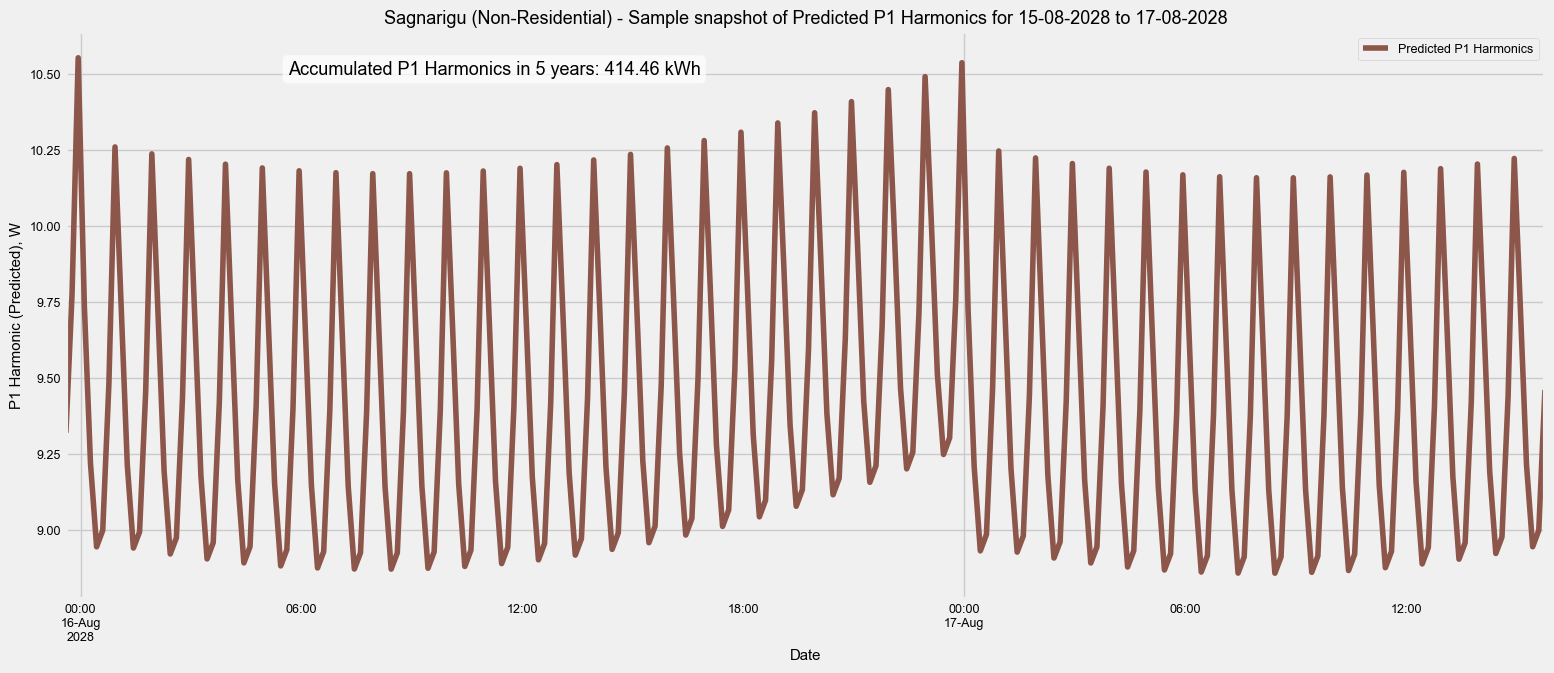

In [54]:
sp1_day = s_p1_future.loc['2028-08-15 23:33:00':'2028-08-17 15:53:00']

ax = sp1_day[['y_pred']].plot(
    figsize=(17,7), 
    label='Predicted P1 Harmonics', 
    color=color_pal[5], 
    title="Sagnarigu (Non-Residential) - Sample snapshot of Predicted P1 Harmonics for 15-08-2028 to 17-08-2028"
)

ax.set_xlabel('Datetime', rotation=0)

# Add text annotation at a specific point
ax.text(0.15, 0.95, f'Accumulated P1 Harmonics in 5 years: {s_p1_future_kWh:0.2f} kWh', transform=ax.transAxes, fontsize=13,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.73))

plt.xlabel('Date')
plt.ylabel('P1 Harmonic (Predicted), W')
plt.grid(True)
plt.legend(['Predicted P1 Harmonics'])

plt.savefig('sag_p1_predicted.jpg', dpi=307)
plt.show()


<br><br>

### Phase 2 (P2)

In [55]:
# The Seed
s_p2_seed = s_p2_.tail(10).copy(deep=True)
s_p2_seed

,P2_Harmonic,hour,minute,dayofweek,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,rolling_var_3,Predictions
Datetime,,,,,,,,,,,
2023-08-23 09:16:00,27.207337,9,16,2,22.273406,17.847080,16.864727,22.442608,4.682422,21.925075,23.471401
2023-08-23 09:26:00,20.960858,9,26,2,27.207337,22.273406,17.847080,23.480534,3.293553,10.847493,24.903169
2023-08-23 09:36:00,20.756177,9,36,2,20.960858,27.207337,22.273406,22.974791,3.666921,13.446310,24.503444
2023-08-23 09:46:00,17.504253,9,46,2,20.756177,20.960858,27.207337,19.740429,1.939288,3.760837,23.323529
2023-08-23 09:56:00,13.717845,9,56,2,17.504253,20.756177,20.960858,17.326092,3.522547,12.408335,22.187882
2023-08-23 10:06:00,17.153666,10,6,2,13.717845,17.504253,20.756177,16.125255,2.092234,4.377444,21.252705
2023-08-23 10:16:00,24.155940,10,16,2,17.153666,13.717845,17.504253,18.342484,5.319626,28.298422,21.475130
2023-08-23 10:26:00,38.335500,10,26,2,24.155940,17.153666,13.717845,26.548369,10.791678,116.460309,36.332638
2023-08-23 10:36:00,33.773654,10,36,2,38.335500,24.155940,17.153666,32.088365,7.238448,52.395131,32.052511


In [56]:
# number of years to predict for.
sp2_n = 5

sp2_start_date = datetime.strptime(str(list(s_p2_seed.index)[0]), '%Y-%m-%d %H:%M:%S')
sp2_end_date = sp2_start_date + relativedelta(years=sp2_n)

sp2_dates = np.array(s_p2_seed.index.astype(str))
sp2_harmonics = np.array(s_p2_seed['P2_Harmonic'].values)
sp2_hr = np.array(s_p2_seed['hour'].values)
sp2_min = np.array(s_p2_seed['minute'].values)
sp2_dow = np.array(s_p2_seed['dayofweek'].values)
sp2_lag_1 = np.array(s_p2_seed['lag_1'].values)
sp2_lag_2 = np.array(s_p2_seed['lag_2'].values)
sp2_lag_3 = np.array(s_p2_seed['lag_3'].values)
sp2_roll_mean_3 = np.array(s_p2_seed['rolling_mean_3'].values)
sp2_roll_std_3 = np.array(s_p2_seed['rolling_std_3'].values)
sp2_roll_var_3 = np.array(s_p2_seed['rolling_var_3'].values)
sp2_y_pred = np.array(s_p2_seed['Predictions'].values)

# Pre-allocate memory for future values
sp2_prediction_horizon = int((sp2_end_date - sp2_start_date).total_seconds() // 600)  # 10-minute increments
sp2_future_dates = np.empty(sp2_prediction_horizon, dtype="U19")  # Pre-allocate date array (string format)
sp2_future_p2_h = np.empty(sp2_prediction_horizon)
sp2_future_lag_1 = np.empty(sp2_prediction_horizon)
sp2_future_lag_2 = np.empty(sp2_prediction_horizon)
sp2_future_lag_3 = np.empty(sp2_prediction_horizon)
sp2_future_roll_mean_3 = np.empty(sp2_prediction_horizon)
sp2_future_roll_std_3 = np.empty(sp2_prediction_horizon)
sp2_future_roll_var_3 = np.empty(sp2_prediction_horizon)
sp2_future_hr = np.empty(sp2_prediction_horizon, dtype=int)
sp2_future_min = np.empty(sp2_prediction_horizon, dtype=int)
sp2_future_dow = np.empty(sp2_prediction_horizon, dtype=int)
sp2_future_y_pred = np.empty(sp2_prediction_horizon)

# Initialize current time from the last date
sp2_current_date = datetime.strptime(sp2_dates[-1], '%Y-%m-%d %H:%M:%S')

j = 0

In [57]:
def sp2_timer():
    start_time = time.time()
    while not task2_done:
        elapsed_time = time.time() - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"\033[1;95mElapsed time: {int(hours):02}:{int(minutes):02}:{int(seconds):02} (Run {j:,} out of {sp2_prediction_horizon:,})", end='\r')
        time.sleep(0.0001)  # Update every second

In [58]:
task2_done = False

timer2_thread = threading.Thread(target=sp2_timer)
timer2_thread.start()

# Loop to generate predictions
while j < sp2_prediction_horizon:
    # Advance time by 10 minutes
    sp2_current_date += timedelta(minutes=10)
    sp2_current_hr = sp2_current_date.hour
    sp2_current_min = sp2_current_date.minute
    sp2_current_dow = sp2_current_date.weekday()
    
    # Append new values to the arrays
    sp2_future_dates[j] = sp2_current_date.strftime('%Y-%m-%d %H:%M:%S')
    sp2_future_hr[j] = sp2_current_hr
    sp2_future_min[j] = sp2_current_min
    sp2_future_dow[j] = sp2_current_dow
    sp2_future_p2_h[j] = sp2_y_pred[-1]  # Previous prediction becomes the new harmonic value
    
    # Update lag features
    sp2_future_lag_1[j] = sp2_future_p2_h[j - 1] if j > 0 else sp2_harmonics[-1]
    sp2_future_lag_2[j] = sp2_future_lag_1[j - 1] if j > 1 else sp2_lag_1[-1]
    sp2_future_lag_3[j] = sp2_future_lag_2[j - 1] if j > 2 else sp2_lag_2[-1]
    
    # Compute rolling statistics (using pre-existing values)
    sp2_window_p2_h = np.concatenate((sp2_harmonics[-2:], sp2_future_p2_h[:j+1]))[-3:]
    sp2_future_roll_mean_3[j] = np.mean(sp2_window_p2_h)
    sp2_future_roll_std_3[j] = np.std(sp2_window_p2_h)
    sp2_future_roll_var_3[j] = np.var(sp2_window_p2_h)
    
    # Construct the input data for the model prediction
    sp2_X = pd.DataFrame({
        'hour': np.concatenate((sp2_hr, sp2_future_hr[:j+1])),
        'minute': np.concatenate((sp2_min, sp2_future_min[:j+1])),
        'dayofweek': np.concatenate((sp2_min, sp2_future_min[:j+1])),
        'lag_1': np.concatenate((sp2_lag_1, sp2_future_lag_1[:j+1])),
        'lag_2': np.concatenate((sp2_lag_2, sp2_future_lag_2[:j+1])),
        'lag_3': np.concatenate((sp2_lag_3, sp2_future_lag_3[:j+1])),
        'rolling_mean_3': np.concatenate((sp2_roll_mean_3, sp2_future_roll_mean_3[:j+1])),
        'rolling_std_3': np.concatenate((sp2_roll_std_3, sp2_future_roll_std_3[:j+1])),
        'rolling_var_3': np.concatenate((sp2_roll_var_3, sp2_future_roll_var_3[:j+1]))
    })
    
    # Predict and append the result
    y_pred2 = s_p2_SVR.predict(sp2_X.iloc[-1:])
    sp2_future_y_pred[j] = y_pred2

    # Update _y_pred for future iterations
    sp2_y_pred = np.append(sp2_y_pred, y_pred2)

    j += 1

task2_done = True
timer2_thread.join()
j

263088

In [59]:
s_p2_future = pd.DataFrame({'Datetime':sp2_future_dates,
                       'P1_Harmonic':sp2_future_p2_h,
                       'hour':sp2_future_hr,
                       'minute':sp2_future_min,
                       'dayofweek':sp2_future_dow,
                       'lag_1':sp2_future_lag_1,
                       'lag_2':sp2_future_lag_2,
                       'lag_3':sp2_future_lag_3,
                       'rolling_mean_3':sp2_future_roll_mean_3,
                       'rolling_std_3':sp2_future_roll_std_3,
                       'rolling_var_3':sp2_future_roll_var_3,
                       'y_pred':sp2_future_y_pred
                      })

In [60]:
s_p2_future = s_p2_future.set_index('Datetime')
s_p2_future.index = pd.to_datetime(s_p2_future.index, format='%Y-%m-%d %H:%M:%S')
s_p2_future

,P1_Harmonic,hour,minute,dayofweek,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,rolling_var_3,y_pred
Datetime,,,,,,,,,,,
2023-08-23 10:56:00,33.130925,10,56,2,30.284204,33.773654,38.335500,32.396261,1.516325,2.299243,34.891599
2023-08-23 11:06:00,34.891599,11,6,2,33.130925,33.773654,38.335500,32.768909,1.898300,3.603542,33.278434
2023-08-23 11:16:00,33.278434,11,16,2,34.891599,33.130925,38.335500,33.766986,0.797498,0.636003,33.701766
2023-08-23 11:26:00,33.701766,11,26,2,33.278434,34.891599,33.130925,33.957266,0.682903,0.466357,33.301176
2023-08-23 11:36:00,33.301176,11,36,2,33.701766,33.278434,34.891599,33.427125,0.194422,0.037800,33.582875
...,...,...,...,...,...,...,...,...,...,...,...
2028-08-23 10:06:00,36.118017,10,6,2,34.958695,34.333532,34.279177,35.136748,0.739312,0.546582,34.203691
2028-08-23 10:16:00,34.203691,10,16,2,36.118017,34.958695,34.333532,35.093468,0.787309,0.619856,34.380934
2028-08-23 10:26:00,34.380934,10,26,2,34.203691,36.118017,34.958695,34.900881,0.863682,0.745946,34.261673


In [61]:
s_p2_future_kWh = s_p2_future['y_pred'].sum()/6000
s_p2_future_kWh

1535.6252930065996

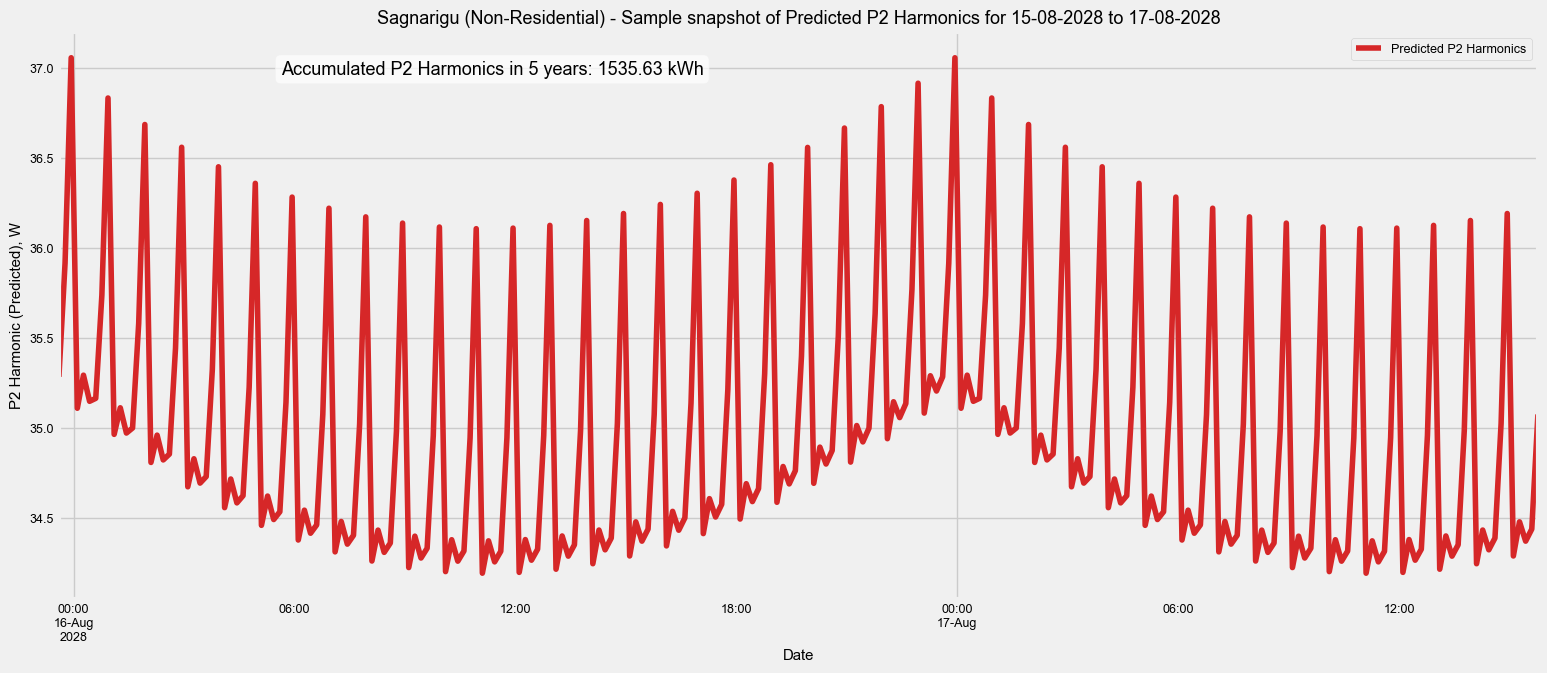

In [71]:
sp2_day = s_p2_future.loc['2028-08-15 23:33:00':'2028-08-17 15:53:00']

ax = sp2_day[['y_pred']].plot(
    figsize=(17,7), 
    label='Predicted P2 Harmonics', 
    color=color_pal[3], 
    title="Sagnarigu (Non-Residential) - Sample snapshot of Predicted P2 Harmonics for 15-08-2028 to 17-08-2028"
)

ax.set_xlabel('Datetime', rotation=0)

# Add text annotation at a specific point
ax.text(0.15, 0.95, f'Accumulated P2 Harmonics in 5 years: {s_p2_future_kWh:0.2f} kWh', transform=ax.transAxes, fontsize=13,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.73))

plt.xlabel('Date')
plt.ylabel('P2 Harmonic (Predicted), W')
plt.grid(True)
plt.legend(['Predicted P2 Harmonics'])

plt.savefig('sag_p2_predicted.jpg', dpi=307)
plt.show()

<br><br>

### Phase 3 (P3)

In [62]:
# The Seed
s_p3_seed = s_p3_.tail(10).copy(deep=True)
s_p3_seed

,P3_Harmonic,hour,minute,dayofweek,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,rolling_var_3,Predictions
Datetime,,,,,,,,,,,
2023-08-23 09:16:00,27.511422,9,16,2,24.700133,20.875723,10.404734,24.362426,3.330715,11.093660,23.869044
2023-08-23 09:26:00,20.317602,9,26,2,27.511422,24.700133,20.875723,24.176386,3.625396,13.143495,25.409821
2023-08-23 09:36:00,27.924533,9,36,2,20.317602,27.511422,24.700133,25.251186,4.277599,18.297851,24.670413
2023-08-23 09:46:00,26.611878,9,46,2,27.924533,20.317602,27.511422,24.951338,4.066251,16.534395,25.415408
2023-08-23 09:56:00,30.102323,9,56,2,26.611878,27.924533,20.317602,28.212911,1.763001,3.108173,26.701642
2023-08-23 10:06:00,23.668799,10,6,2,30.102323,26.611878,27.924533,26.794333,3.220640,10.372525,28.677009
2023-08-23 10:16:00,40.568815,10,16,2,23.668799,30.102323,26.611878,31.446646,8.529832,72.758038,30.629660
2023-08-23 10:26:00,47.313582,10,26,2,40.568815,23.668799,30.102323,37.183732,12.180436,148.363031,43.697123
2023-08-23 10:36:00,44.944526,10,36,2,47.313582,40.568815,23.668799,44.275641,3.421772,11.708526,38.762329


In [63]:
# number of years to predict for.
sp3_n = 5

sp3_start_date = datetime.strptime(str(list(s_p3_seed.index)[0]), '%Y-%m-%d %H:%M:%S')
sp3_end_date = sp3_start_date + relativedelta(years=sp3_n)

sp3_dates = np.array(s_p3_seed.index.astype(str))
sp3_harmonics = np.array(s_p3_seed['P3_Harmonic'].values)
sp3_hr = np.array(s_p3_seed['hour'].values)
sp3_min = np.array(s_p3_seed['minute'].values)
sp3_dow = np.array(s_p3_seed['dayofweek'].values)
sp3_lag_1 = np.array(s_p3_seed['lag_1'].values)
sp3_lag_2 = np.array(s_p3_seed['lag_2'].values)
sp3_lag_3 = np.array(s_p3_seed['lag_3'].values)
sp3_roll_mean_3 = np.array(s_p3_seed['rolling_mean_3'].values)
sp3_roll_std_3 = np.array(s_p3_seed['rolling_std_3'].values)
sp3_roll_var_3 = np.array(s_p3_seed['rolling_var_3'].values)
sp3_y_pred = np.array(s_p3_seed['Predictions'].values)

# Pre-allocate memory for future values
sp3_prediction_horizon = int((sp3_end_date - sp3_start_date).total_seconds() // 600)  # 10-minute increments
sp3_future_dates = np.empty(sp3_prediction_horizon, dtype="U19")  # Pre-allocate date array (string format)
sp3_future_p3_h = np.empty(sp3_prediction_horizon)
sp3_future_lag_1 = np.empty(sp3_prediction_horizon)
sp3_future_lag_2 = np.empty(sp3_prediction_horizon)
sp3_future_lag_3 = np.empty(sp3_prediction_horizon)
sp3_future_roll_mean_3 = np.empty(sp3_prediction_horizon)
sp3_future_roll_std_3 = np.empty(sp3_prediction_horizon)
sp3_future_roll_var_3 = np.empty(sp3_prediction_horizon)
sp3_future_hr = np.empty(sp3_prediction_horizon, dtype=int)
sp3_future_min = np.empty(sp3_prediction_horizon, dtype=int)
sp3_future_dow = np.empty(sp3_prediction_horizon, dtype=int)
sp3_future_y_pred = np.empty(sp3_prediction_horizon)

# Initialize current time from the last date
sp3_current_date = datetime.strptime(sp3_dates[-1], '%Y-%m-%d %H:%M:%S')

k = 0

In [64]:
def sp3_timer():
    start_time = time.time()
    while not task3_done:
        elapsed_time = time.time() - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"\033[1;95mElapsed time: {int(hours):02}:{int(minutes):02}:{int(seconds):02} (Run {k:,} out of {sp3_prediction_horizon:,})", end='\r')
        time.sleep(0.0001)  # Update every second

In [65]:
task3_done = False

timer3_thread = threading.Thread(target=sp3_timer)
timer3_thread.start()

# Loop to generate predictions
while k < sp3_prediction_horizon:
    # Advance time by 10 minutes
    sp3_current_date += timedelta(minutes=10)
    sp3_current_hr = sp3_current_date.hour
    sp3_current_min = sp3_current_date.minute
    
    # Append new values to the arrays
    sp3_future_dates[k] = sp3_current_date.strftime('%Y-%m-%d %H:%M:%S')
    sp3_future_hr[k] = sp3_current_hr
    sp3_future_min[k] = sp3_current_min
    sp3_future_p3_h[k] = sp3_y_pred[-1]  # Previous prediction becomes the new harmonic value
    
    # Update lag features
    sp3_future_lag_1[k] = sp3_future_p3_h[k - 1] if k > 0 else sp3_harmonics[-1]
    sp3_future_lag_2[k] = sp3_future_lag_1[k - 1] if k > 1 else sp3_lag_1[-1]
    sp3_future_lag_3[k] = sp3_future_lag_2[k - 1] if k > 2 else sp3_lag_2[-1]

    # Compute rolling statistics (using pre-existing values)
    sp3_window_p3_h = np.concatenate((sp3_harmonics[-2:], sp3_future_p3_h[:k+1]))[-3:]
    sp3_future_roll_mean_3[k] = np.mean(sp3_window_p3_h)
    sp3_future_roll_std_3[k] = np.std(sp3_window_p3_h)

    # Construct the input data for the model prediction
    sp3_X = pd.DataFrame({
        'hour': np.concatenate((sp3_hr, sp3_future_hr[:k+1])),
        'minute': np.concatenate((sp3_min, sp3_future_min[:k+1])),
        'dayofweek': np.concatenate((sp3_dow, sp3_future_dow[:k+1])),
        'lag_1': np.concatenate((sp3_lag_1, sp3_future_lag_1[:k+1])),
        'lag_2': np.concatenate((sp3_lag_2, sp3_future_lag_2[:k+1])),
        'lag_3': np.concatenate((sp3_lag_3, sp3_future_lag_3[:k+1])),
        'rolling_mean_3': np.concatenate((sp3_roll_mean_3, sp3_future_roll_mean_3[:k+1])),
        'rolling_std_3': np.concatenate((sp3_roll_std_3, sp3_future_roll_std_3[:k+1])),
        'rolling_var_3': np.concatenate((sp3_roll_var_3, sp3_future_roll_var_3[:k+1]))
    })
    
    # Predict and append the result
    y_pred3 = s_p3_SVR.predict(sp3_X.iloc[-1:])
    sp3_future_y_pred[k] = y_pred3

    # Update _y_pred for future iterations
    sp3_y_pred = np.append(sp3_y_pred, y_pred3)

    k += 1

In [66]:
task3_done = True
timer3_thread.join()
k

263088

In [67]:
s_p3_future = pd.DataFrame({'Datetime':sp3_future_dates,
                       'P3_Harmonic':sp3_future_p3_h,
                       'hour':sp3_future_hr,
                       'minute':sp3_future_min,
                       'dayofweek':sp3_future_dow,
                       'lag_1':sp3_future_lag_1,
                       'lag_2':sp3_future_lag_2,
                       'lag_3':sp3_future_lag_3,
                       'rolling_mean_3':sp3_future_roll_mean_3,
                       'rolling_std_3':sp3_future_roll_std_3,
                       'rolling_var_3':sp3_future_roll_var_3,
                       'y_pred':sp3_future_y_pred
                      })

In [68]:
s_p3_future = s_p3_future.set_index('Datetime')
s_p3_future.index = pd.to_datetime(s_p3_future.index, format='%Y-%m-%d %H:%M:%S')
s_p3_future

,P3_Harmonic,hour,minute,dayofweek,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,rolling_var_3,y_pred
Datetime,,,,,,,,,,,
2023-08-23 10:56:00,41.887705,10,56,4625716724109482111,32.938183,44.944526,47.313582,39.923471,5.094554,0.0,67.526271
2023-08-23 11:06:00,67.526271,11,6,4626962624117245881,41.887705,44.944526,47.313582,47.450720,14.658202,0.0,67.526271
2023-08-23 11:16:00,67.526271,11,16,4628351402230562865,67.526271,41.887705,47.313582,58.980083,12.086136,0.0,67.526271
2023-08-23 11:26:00,67.526271,11,26,4626593174699514263,67.526271,67.526271,41.887705,67.526271,0.000000,0.0,67.526271
2023-08-23 11:36:00,67.526271,11,36,4626535562119806148,67.526271,67.526271,67.526271,67.526271,0.000000,0.0,67.526271
...,...,...,...,...,...,...,...,...,...,...,...
2028-08-23 10:06:00,28.274425,10,6,0,28.296842,28.409786,28.554750,28.327018,0.059237,0.0,29.280013
2028-08-23 10:16:00,29.280013,10,16,0,28.274425,28.296842,28.409786,28.617093,0.468844,0.0,28.754483
2028-08-23 10:26:00,28.754483,10,26,0,29.280013,28.274425,28.296842,28.769640,0.410670,0.0,28.620689


In [69]:
s_p3_future_kWh = s_p3_future['y_pred'].sum()/6000
s_p3_future_kWh

1365.8625074651345

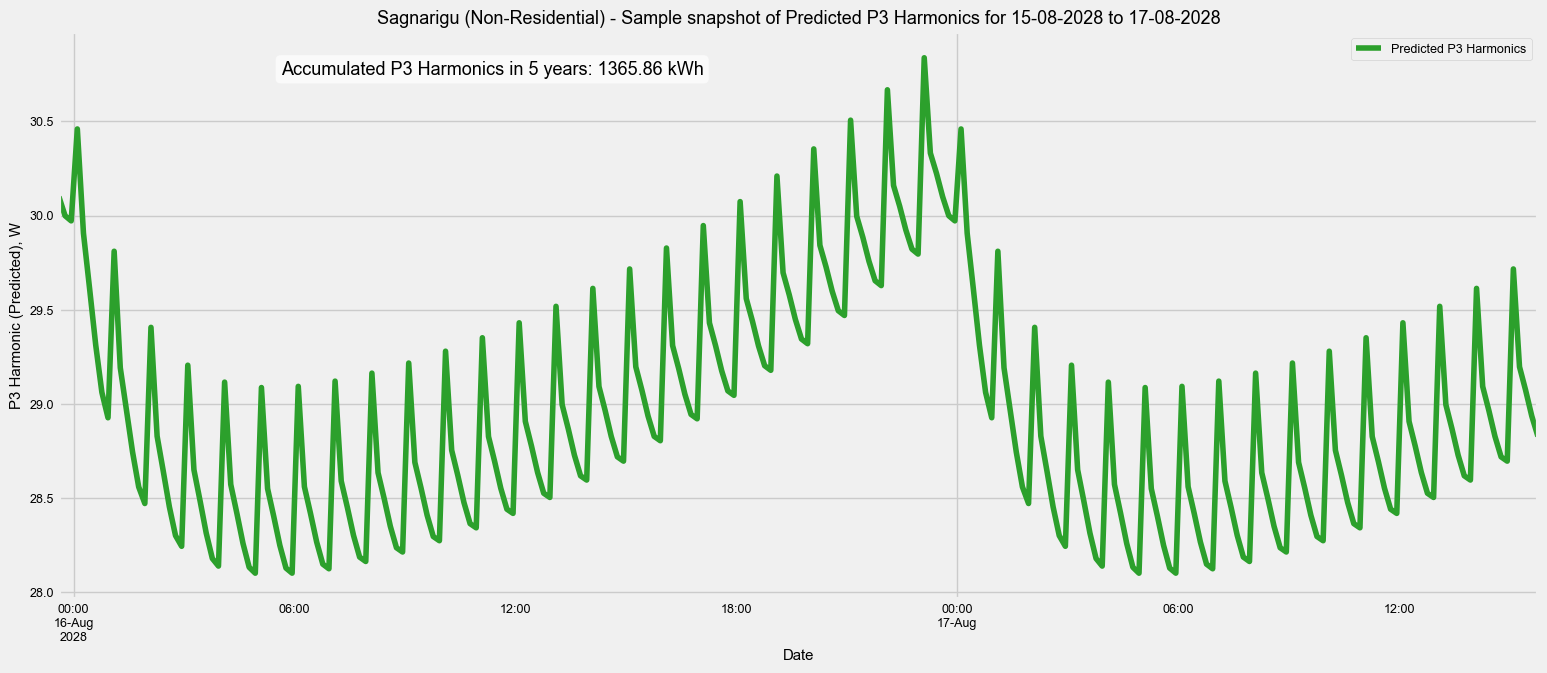

In [70]:
sp3_day = s_p3_future.loc['2028-08-15 23:33:00':'2028-08-17 15:53:00']

ax = sp3_day[['y_pred']].plot(
    figsize=(17,7), 
    label='Predicted P3 Harmonics', 
    color=color_pal[2], 
    title="Sagnarigu (Non-Residential) - Sample snapshot of Predicted P3 Harmonics for 15-08-2028 to 17-08-2028"
)

ax.set_xlabel('Datetime', rotation=0)

# Add text annotation at a specific point
ax.text(0.15, 0.95, f'Accumulated P3 Harmonics in 5 years: {s_p3_future_kWh:0.2f} kWh', transform=ax.transAxes, fontsize=13,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.73))

plt.xlabel('Date')
plt.ylabel('P3 Harmonic (Predicted), W')
plt.grid(True)
plt.legend(['Predicted P3 Harmonics'])

plt.savefig('sag_p3_predicted.jpg', dpi=307)
plt.show()

<br>

### Summary information

In [90]:
s_tot_harmonic_5y = s_p1_future_kWh + s_p2_future_kWh + s_p3_future_kWh
print(f"Total Harmonics for Guss in 5 years: {s_tot_harmonic_5y:.02f} kWh")

Total Harmonics for Guss in 5 years: 3315.95 kWh


### Cost in Money of Harmonics

In [91]:
#cost of electricity...
def energyCost(x: float, residential=True, tag='') -> float:
    """
    Arguments:
        x = Energy, kWh.
        residential
            True: Residential
            False: Non-Residential
            
        tag = ''
            slt-lv, slt-mv, slt-hv, slt-hv steel, slt-hv mines. 
            (special load tariff for non-residential customers)
        
    Returns:
        A tuple of
        (electricity_charge, lighting_levy, national_electrification_levy, service_charge, NHIL, VAT, total_charge)
    """
    
    total_charge = 0.0
    electricityCost = 0.0
    service_charge = 0.0
    lighting_levy = 0.0
    nat_elec_levy = 0.0
    VAT = 0.0; NHIL = 0.0;
    if(residential): #Residential Customer.
        
        if((x >= 0) and (x <= 30)): #lifeline customer...
            service_charge = 2.13
            electricityCost = (0.634792 * x) 
        else:
            service_charge = 10.730886
            if ((x > 30) and (x <= 300)):
                electricityCost = (0.634792 * 30) + (1.405722 * (x - 30))
            elif ((x > 300)):# and (x <= 600)):
                electricityCost = (0.634792 * 30) + (1.405722 * 270)  + (1.857432 * (x - 300))
            #elif (x > 600):
            #    electricityCost = (0.544627 * 30) + (1.157212 * 270)  + (1.501837 * 300) + (1.668708 * (x - 600))
        
        #calculating total energy cost.
        lighting_levy = 0.03 * electricityCost
        nat_elec_levy = 0.02 * electricityCost
        total_charge = electricityCost + lighting_levy + nat_elec_levy + service_charge
    
    else: #Nonresidential Customer.
        if (tag == ''):
            service_charge = 12.428245
            if ((x >= 0) and (x <= 300)):
                electricityCost = (1.269145 * x)
            elif ((x > 300)):# and (x <= 600)):
                electricityCost = (1.269145 * 300) + (1.577242 * (x - 300))
            #elif (x > 600):
            #    electricityCost = (1.088876 * 300) + (1.158681 * 300) + (1.729692 * (x - 600))
        else: #Special load tariffs.
            service_charge = 500.00
            if ('lv' in tag.lower()): 
                electricityCost = (x * 1.723461)
            elif ('mv' in tag.lower()):
                electricityCost = (x * 1.308541)
            elif ('steel' in tag.lower()):
                electricityCost = (x * 0.968627)
            elif (tag.lower() == 'mines'):
                electricityCost = (x * 3.430618)
            elif ('hv' in tag.lower()):
                electricityCost = (x * 1.373370)
            
        #other tariffs...
        lighting_levy = 0.03 * electricityCost
        nat_elec_levy = 0.02 * electricityCost
        pre_tax = lighting_levy + nat_elec_levy + service_charge + electricityCost
        NHIL = 0.05 * (pre_tax)
        VAT = 0.15 * (NHIL + pre_tax)
        total_charge = pre_tax + VAT + NHIL
                
    return total_charge

In [92]:
monthly_kWh = s_tot_harmonic_5y / (5*12)
total_GHS_5y = 5 * 12 * energyCost(monthly_kWh, residential=False)

print(f"For a 5 year sum of {s_tot_harmonic_5y:.02f} kWh ({monthly_kWh:.02f} kWh monthly), equivalent to GHS {total_GHS_5y:0.2f} over 5 years") 

For a 5 year sum of 3315.95 kWh (55.27 kWh monthly), equivalent to GHS 6236.17 over 5 years


In [259]:
monthly_kWh = s_tot_harmonic_5y #/ (5*12)
total_GHS_5y = 5 * 12 * energyCost(monthly_kWh, residential=False)
print(f"For a 5 year sum of {s_tot_harmonic_5y:.02f} kWh ({monthly_kWh:.02f} kWh monthly), equivalent to GHS {total_GHS_5y:0.2f} over 5 years") 

For a 5 year sum of 3223.85 kWh (53.73 kWh monthly), equivalent to GHS 6087.99 over 5 years


<br><br><br>

## Smooth the Patterns to Reveal the Seasonality.

The graphs of the predictions into the future follows the seasonality observed in the actual data. The following snapshots reveals this information.

In [160]:
from scipy.signal import savgol_filter

### P1 using Savgol Filter

In [269]:
# Create a copy
s_p1_sv = s_p1.copy(deep = True)
s_p1_sv = s_p1_sv.drop(columns=['hour', 'minute', 'dayofweek'])

<Axes: xlabel='Datetime'>

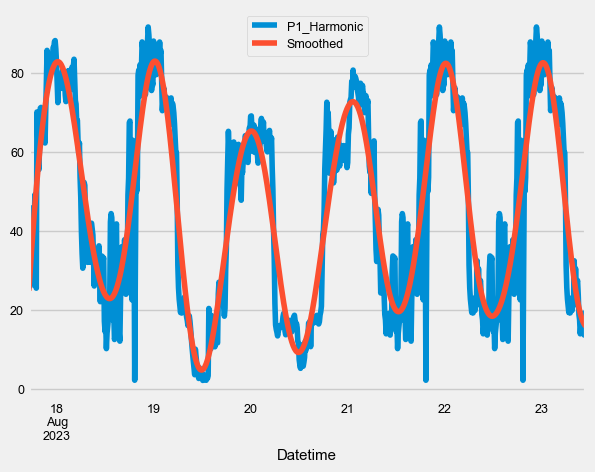

In [271]:
#Smoothening the data 3 times to see how it affects accuracy.
s_p1_sv['Smoothed'] = savgol_filter(s_p1_sv['P1_Harmonic'], window_length=7, polyorder=2)
for _ in range(1,37777):
    s_p1_sv['Smoothed'] = savgol_filter(s_p1_sv['Smoothed'], window_length=7, polyorder = 2)

s_p1_sv.plot()

<br><br>

### P2 using Savgol Filter

In [264]:
# Create a copy
s_p2_sv = s_p2.copy(deep = True)
s_p2_sv = s_p2_sv.drop(columns=['hour', 'minute', 'dayofweek'])

<Axes: xlabel='Datetime'>

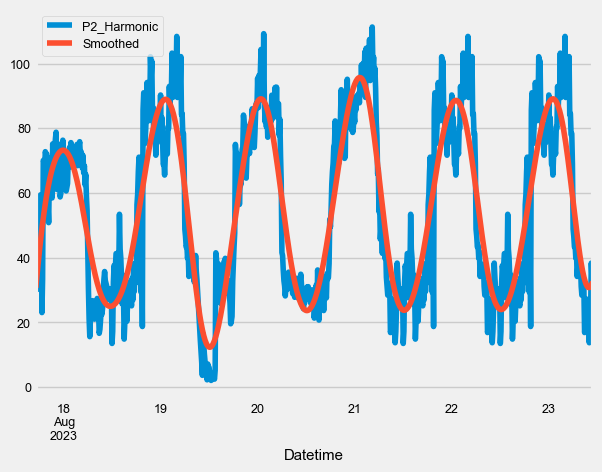

In [265]:
#Smoothening the data 3 times to see how it affects accuracy.
s_p2_sv['Smoothed'] = savgol_filter(s_p2_sv['P2_Harmonic'], window_length=7, polyorder=2)
for _ in range(1,30000):
    s_p2_sv['Smoothed'] = savgol_filter(s_p2_sv['Smoothed'], window_length=7, polyorder = 2)

s_p2_sv.plot()

<br><br>

### P3 using Savgol Filter

In [266]:
# Create a copy
s_p3_sv = s_p3.copy(deep = True)
s_p3_sv = s_p3_sv.drop(columns=['hour', 'minute', 'dayofweek'])

<Axes: xlabel='Datetime'>

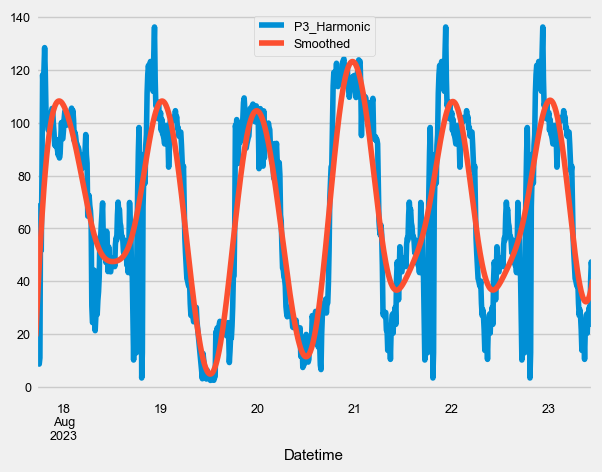

In [268]:
#Smoothening the data 3 times to see how it affects accuracy.
s_p3_sv['Smoothed'] = savgol_filter(s_p3_sv['P3_Harmonic'], window_length=7, polyorder=2)
for _ in range(1,30000):
    s_p3_sv['Smoothed'] = savgol_filter(s_p3_sv['Smoothed'], window_length=7, polyorder = 2)

s_p3_sv.plot()